## Kütüphaneler

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import torch
from warnings import filterwarnings
filterwarnings('ignore')

## Veri Önişleme

In [2]:
train=pd.read_csv("train.csv")
test_df=pd.read_csv("test_x.csv")
data=train.copy()

In [3]:
data.head()

,index,Cinsiyet,Yaş Grubu,Medeni Durum,Eğitim Düzeyi,İstihdam Durumu,Yıllık Ortalama Gelir,Yaşadığı Şehir,En Çok İlgilendiği Ürün Grubu,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Eğitime Devam Etme Durumu,Öbek İsmi,Yıllık Ortalama Sepete Atılan Ürün Adedi
0,0,Kadın,31-40,Bekar,Yüksek Lisans Mezunu,Düzenli ve Ücretli Bir İşi Var,748266.440879,Büyük Şehir,Elektronik ve Teknolojik Ürünler,32010.900881,37.310644,Etmiyor,obek_4,102.936904
1,1,Erkek,>60,Evli,Lise Mezunu,Kendi İşinin Sahibi,246298.609605,Küçük Şehir,Spor Malzemeleri,4145.729891,11.554851,Etmiyor,obek_5,82.176053
2,2,Erkek,18-30,Bekar,Lise Mezunu,Düzenli ve Ücretli Bir İşi Var,268582.732360,Küçük Şehir,Giyim,9924.379414,55.353236,Ediyor,obek_8,141.661426
3,3,Erkek,51-60,Evli,Lise Mezunu,Kendi İşinin Sahibi,327721.837865,Kırsal,Giyim,6417.780714,15.417239,Etmiyor,obek_3,17.097397
4,4,Erkek,31-40,Evli,Ortaokul Mezunu,İşsiz veya Düzenli Bir İşi Yok,397431.626948,Büyük Şehir,Giyim,7886.663061,14.689837,Etmiyor,obek_3,20.470459


Lüzumsuz değişkenleri silelim

In [4]:
data.drop("index",axis=1,inplace=True)

Eksik verileri gözden geçirelim

In [5]:
data.isnull().sum().sum() # :)

0

Gürültülü verileri gözden geçirelim

  File "C:\Users\Selman\AppData\Roaming\Python\Python39\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


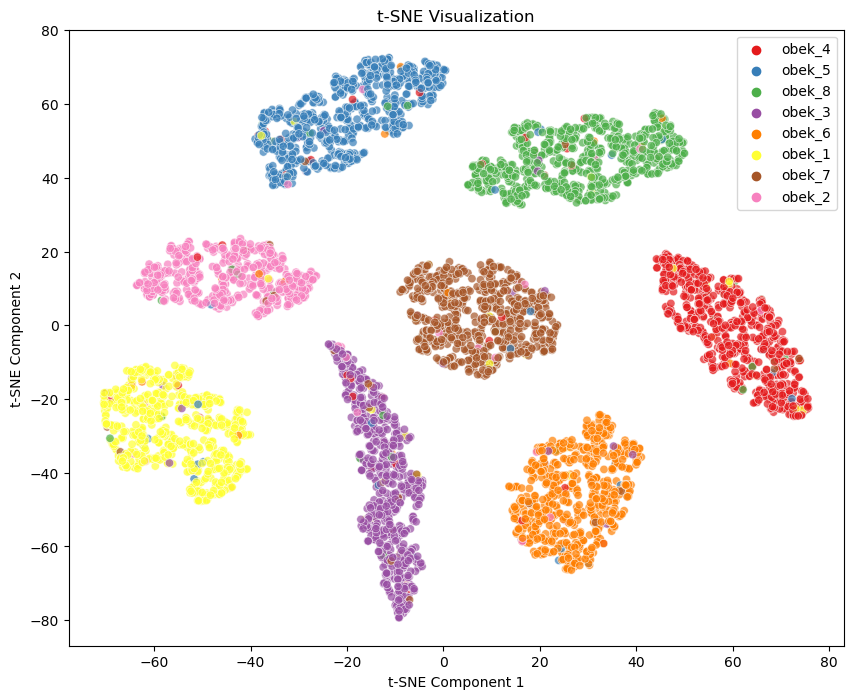

In [6]:
tsne_features = ['Yıllık Ortalama Gelir', 'Yıllık Ortalama Satın Alım Miktarı', 'Yıllık Ortalama Sipariş Verilen Ürün Adedi', 'Yıllık Ortalama Sepete Atılan Ürün Adedi']
data_normalized = (data[tsne_features] - data[tsne_features].mean()) / data[tsne_features].std()

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_normalized)

tsne_df = pd.DataFrame(data=tsne_result, columns=['t-SNE Component 1', 't-SNE Component 2'])
tsne_df['Target'] = data['Öbek İsmi']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='Target', data=tsne_df, palette='Set1', alpha=0.7)
plt.title('t-SNE Visualization')
plt.legend()
plt.savefig('result.png')
plt.show()

Gürültülü veriler var gibi gözüküyor

*

Veri setinin dağılımları

In [7]:
data.describe().round(3)

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi
count,5460.000,5460.000,5460.000,5460.000
mean,363571.133,16616.612,24.041,73.446
std,219714.442,14099.172,14.946,47.214
min,43922.989,2859.254,0.000,3.978
25%,215693.439,4931.859,11.551,25.009
50%,286925.436,8426.819,20.096,82.486
75%,468188.222,30579.245,35.918,104.473
max,1192437.145,48605.594,64.616,242.308


Görünürde değişkenlerin dağılımının çarpık olduğu göze çarpıyor fakat karar vermek için yeterli bir istatistik değil.

In [8]:
data.corr().round(5)

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi
Yıllık Ortalama Gelir,1.00000,0.74024,0.44440,0.14543
Yıllık Ortalama Satın Alım Miktarı,0.74024,1.00000,0.41850,0.13386
Yıllık Ortalama Sipariş Verilen Ürün Adedi,0.44440,0.41850,1.00000,0.65945
Yıllık Ortalama Sepete Atılan Ürün Adedi,0.14543,0.13386,0.65945,1.00000


Yıllık ortalama geliri fazla olanlar pahalı olan ürünlerden az alıyor.
Yıllık ortalama geliri az olanlar ucuz ve daha fazla ürün alıyor.


*

Isı haritası ile korelasyonlara bakalım

<AxesSubplot:>

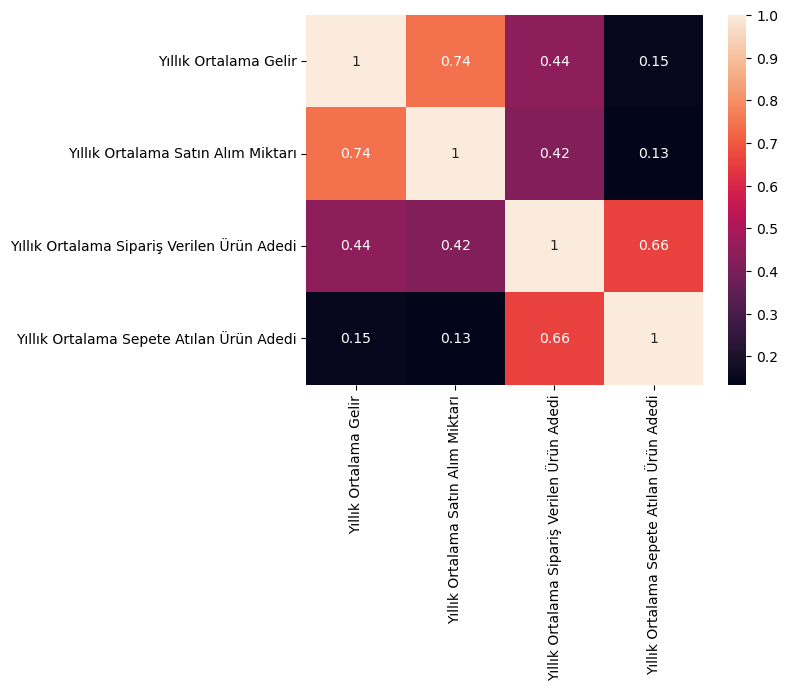

In [9]:
sns.heatmap(data.corr(), annot=True)

Object değişkenlerin kategorik değişkene çevrilmesi

In [10]:
columns_l = list(data.columns)
categorical_columns = []

object_to_category = False

for i in columns_l:
    if data[i].dtype == 'object' or data[i].dtype.name == 'category':
        categorical_columns.append(i)
        if data[i].dtype == 'object':
            object_to_category = True  # En az bir "object" tipinde sütun bulundu

for column in categorical_columns:
    if data[column].dtype == 'object':
        data[column] = data[column].astype('category')

if object_to_category:
    print("Kategorik değişkene çevrilenler:")
    for column in categorical_columns:
        if data[column].dtype == 'category':
            print(column)
else:
    print("Object tipinde kolon yok.")
    """
    Çoğu AI algoritmasında kategorik değişkenler object tipindeki değişkenlerden daha başarılı olduğu için
    objectten kategorik veriye çevirdik
    """

Kategorik değişkene çevrilenler:
Cinsiyet
Yaş Grubu
Medeni Durum
Eğitim Düzeyi
İstihdam Durumu
Yaşadığı Şehir
En Çok İlgilendiği Ürün Grubu
Eğitime Devam Etme Durumu
Öbek İsmi


Kategorik değişkenleri kullanmak için belirleyelim

In [11]:
category_colons = []
for column in data.columns:
    if data[column].dtype == "category":
        category_colons.append(column)
    else:
        pass
category_colons

['Cinsiyet',
 'Yaş Grubu',
 'Medeni Durum',
 'Eğitim Düzeyi',
 'İstihdam Durumu',
 'Yaşadığı Şehir',
 'En Çok İlgilendiği Ürün Grubu',
 'Eğitime Devam Etme Durumu',
 'Öbek İsmi']

Kategorik değişkenlerin sınıf etiketlerinin frekanslarına bakalım

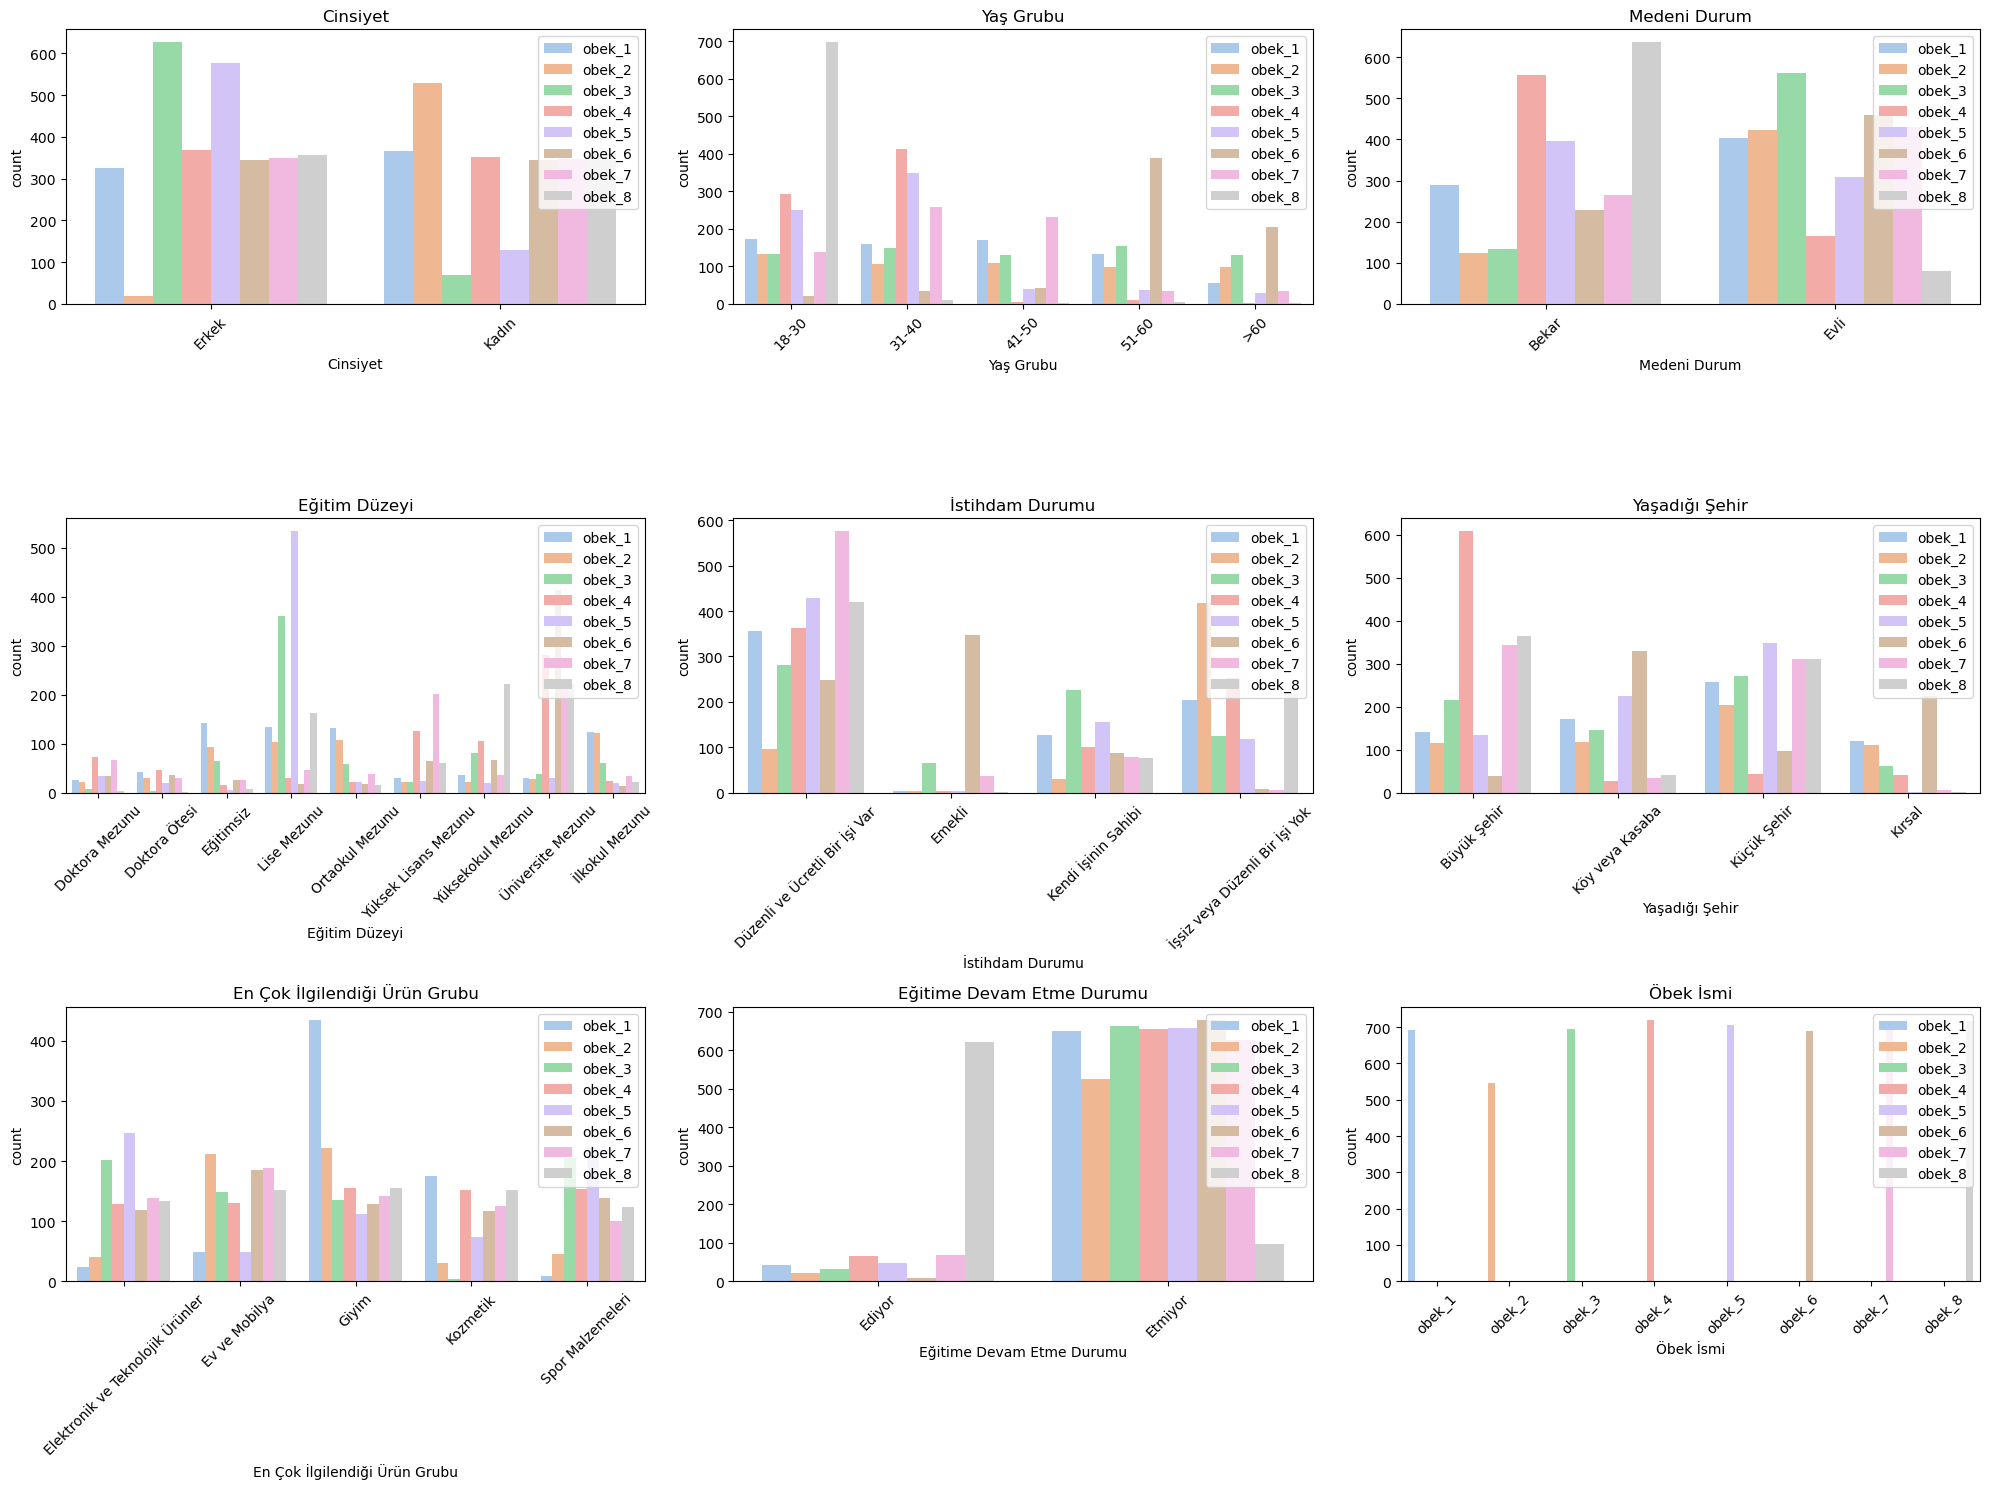

In [12]:
# Pastel renk paletini oluşturun
pastel_palette = sns.color_palette("pastel")

# Figure oluşturma
plt.figure(figsize=(20, 15))

# Her bir özellik için grafik oluşturma
for idx, feature in enumerate(category_colons, 1):
    plt.subplot(3, 3, idx)
    sns.countplot(data=data, x=feature, hue='Öbek İsmi', palette=pastel_palette)
    plt.title(feature)
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Cinsiyet: Bazı öbeklerde cinsiyet farklılığı görünüyor. Örneğin öbek 2'de kadın oranı fazlayken, öbek 5 ve öbek 3'de erkek oranı fazla.
Yaş Grubu: öbek 1, öbek 2, öbek 3'de yaş aralığı eşit oranda dağılmış gibi görünüyor.
Öbek 4 ve öbek 5'de 18-40 yaş arası çoğunlukta. Öbek 6'da 51-60 ve 60 üstü yaş aralığı çoğunlukta görünüyor. öbek 7'de 31-50 yaş aralığı fazla görünüyor ve arkasından 18-30 yaş aralığı geliyor.
Öbek 8'de 18-30 yaş aralığı ezici çoğunlukta.
Medeni Durum: öbek 4 ve öbek 8'de bekarlar fazla iken, öbek 3, öbek 6, öbek 1 öbek 7 ve öbek 2'de evliler fazla görünüyor. öbek 5'de eşite yakın bir dağılım var.
Eğitim Düzeyi: öbek 1 ve öbek 2'de eğitimsiz, ilkokul, ortaokul ve lise mezunları fazlalıkta. öbek 3'de, öbek 5'de ve öbek 8'de lise mezunları fazlalıkta. öbek 4'de ve öbek 6'da üniversite mezunları fazlalıkta. öbek 7'de üniversite ve yüksek lisans mezunları fazlalıkta.
İstihdam Durumu: Emekliler öbek 6'da çoğunlukta. öbek 7 ve öbek 6'da işsiz veya düzenli işi olmayanlar azınlıkta. düzenli ve ücretli bir işi olanlar öbek 2'de azınlıkta, diğer öbeklerde orantılı bir dağılım var.
Yaşadığı Şehir: Büyük şehirde yaşayanların çoğunluğu öbek 4'de. öbek 6'nın çoğunluğu kırsal, köy veya kasabada yaşıyor.
Eğitime Devam: Öbek 8 eğitime devam ediyor.
Öbek 1: Eşit cinsiyet, eşit yaş ama 60 yaş üstü azınlıkta, evliler fazla, eğitimsiz, ilkokul, ortaokul, lise mezunları, emekli ve kendi işinin sahibi olanlar az, yaşadıkları şehirler eşit sayılır, eğitime devam etmiyorlar, en çok giyim ile ilgileniyorlar. (memur ve işçi kesimi)
Öbek 2: Kadın fazlalıkta, yaş dağılımı eşit, evliler fazla, eğitimsiz, ilkokul, ortaokul ve lise mezunları fazla, işsizler, yaşadıkları şehirler eşit dağılım, eğitime devam yok, giyim ev ve mobilya en çok alınanlar (ev hanımları)
Öbek 3: Erkek, yaş aralığı eşit, evli, lise mezunu, düzenli işi var veya kendi işinin sahibi, küçük şehir biraz çoğunlukta, eğitime devam etmiyor, kozmetik almıyor (erkekler)
Öbek 4: Eşit cinsiyet, 18-40 yaş aralığı, bekar, üniversite mezunu, düzenli ve ücretli bir işi var ve işsizler çoğunlukta, büyük şehirde yaşıyorlar, ilgilenilen ürünler eşit, eğitime devam etmiyor (mezun çalışan)
Öbek 5: Erkek, 18-40 yaş aralığı, medeni durum eşit gibi, lise mezunu, düzenli ve ücretli işleri var, küçük şehir ya da köy veya kasabada yaşıyorlar, eğitime devam etmiyorlar, elektronik ve teknolojik ve spor malzemeleri alıyorlar (öbek 3 ile aynı gibi)
Öbek 6: Eşit cinsiyet, 51-60 ve 60 yaş üstü, evlilik çoğunlukta, üniversite mezunları, emekli ya da düzenli ve ücretli işleri var, kırsal, köy veya kasabada yaşıyorlar, her ürünle eşit ilgeniyorlar, eğitime devam yok (emekliler)
Öbek 7: Eşit cinsiyet, 31-50 yaş aralığı fazla, evliler, üniversite ve yüksek lisans mezunları, düzenli işleri var, büyük ve küçük şehirlerde yaşıyorlar, ev ve mobilya ilgileniyorlar, eğitime devam etmiyorlar (beyaz yaka)
Öbek 8: Eşit cinsiyet, 18-30 yaş, bekar, lise, yüksekokul, üniversite mezunları, düzenli ve ücretli işleri var, büyük ve küçük şehirlerde yaşıyorlar, ilgilendikleri ürünler orantılı, eğitime devam ediyorlar

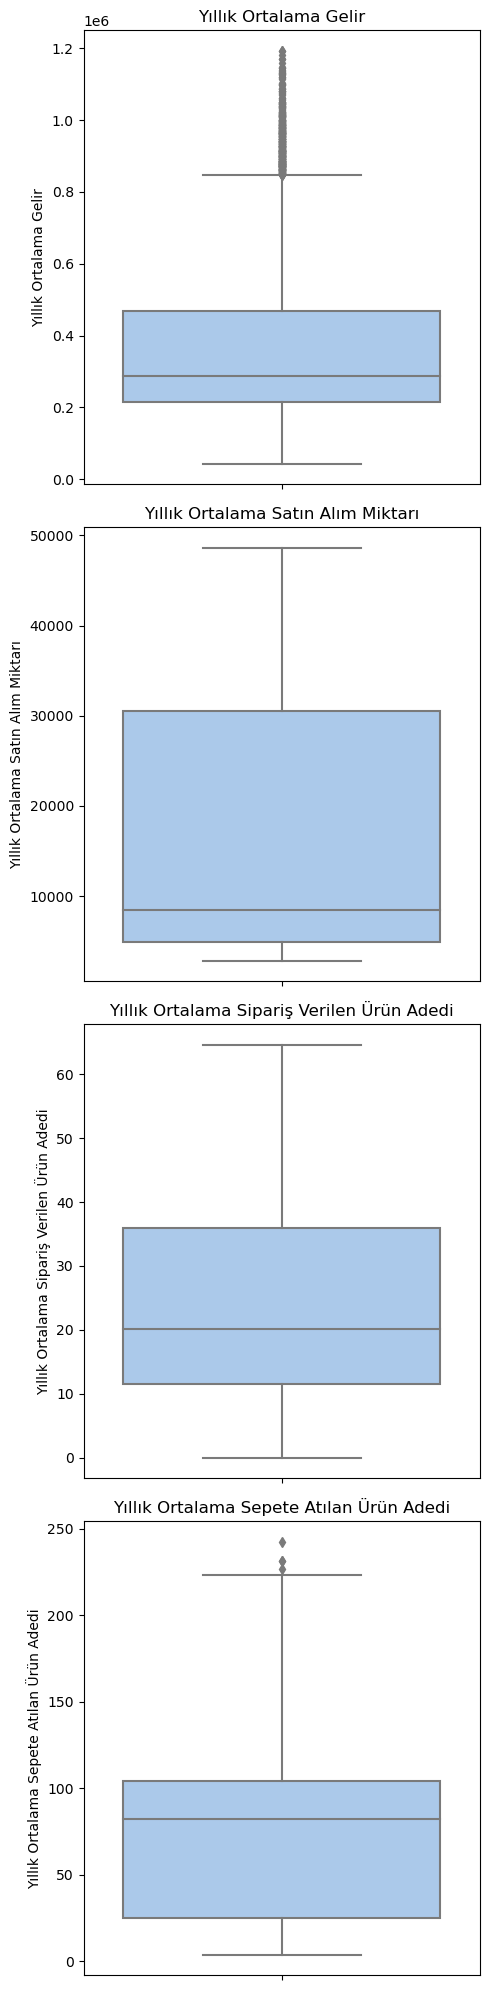

In [13]:
numeric_columns = data.select_dtypes(include=['float64', 'int64'])
pastel_palette = sns.color_palette("pastel")
fig, axes = plt.subplots(nrows=len(numeric_columns.columns), ncols=1, figsize=(5, 20))
for i, column in enumerate(numeric_columns.columns):
    try:
        sns.boxplot(data=data, y=column, ax=axes[i], palette=pastel_palette)
        axes[i].set_title(column)
    except:
        pass
plt.tight_layout()
plt.show()

Veri setinin yapısının bozulmasını istemediğimiz için aykırı verilere dokunmuyoruz

*

Hedef değişkendeki yapısal bozuklukları gidermek

In [14]:
data["Öbek İsmi"].value_counts()

obek_4    720
obek_8    717
obek_5    706
obek_3    695
obek_7    695
obek_1    692
obek_6    688
obek_2    547
Name: Öbek İsmi, dtype: int64

öbek2 sınıfının diğer sınıflara göre az olduğu için oversampling yapacağız

In [15]:
df_2 = data[data["Öbek İsmi"] == "obek_2"]     
desired_sample_count = 150
df_2_upsampled = resample(df_2, replace=True, n_samples=desired_sample_count, random_state=12)
df_2_upsampled.shape

(150, 13)

In [16]:
balanced_data = pd.concat([data, df_2_upsampled])
balanced_data["Öbek İsmi"].value_counts()

obek_4    720
obek_8    717
obek_5    706
obek_2    697
obek_3    695
obek_7    695
obek_1    692
obek_6    688
Name: Öbek İsmi, dtype: int64

In [17]:
#train datamızı train test diyeayıracağız ve train da ,y, sonuç vereni topyekün denicez

In [18]:
#datamızı standartlaştıralım

In [23]:
df_x=balanced_data.drop("Öbek İsmi",axis=1)
df_y=balanced_data["Öbek İsmi"]

In [26]:
import pandas as pd
#girdi--> data

df = df_x

# Kategorik sütunlara dönüşüm ve (n-1) kuralı uygulama
categorical_columns = df.select_dtypes(include=["category"]).columns

for column in categorical_columns:
    dummies = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop(column, axis=1, inplace=True)
    
df_x=df

In [27]:
data=df_x

dumy_colons = []
for column in data.columns:
    if data[column].dtype == "uint8":
        dumy_colons.append(column)
    else:
        pass
dumy_colons
df_x=data

In [28]:
dumy_colons

['Cinsiyet_Kadın',
 'Yaş Grubu_31-40',
 'Yaş Grubu_41-50',
 'Yaş Grubu_51-60',
 'Yaş Grubu_>60',
 'Medeni Durum_Evli',
 'Eğitim Düzeyi_Doktora Ötesi',
 'Eğitim Düzeyi_Eğitimsiz',
 'Eğitim Düzeyi_Lise Mezunu',
 'Eğitim Düzeyi_Ortaokul Mezunu',
 'Eğitim Düzeyi_Yüksek Lisans Mezunu',
 'Eğitim Düzeyi_Yüksekokul Mezunu',
 'Eğitim Düzeyi_Üniversite Mezunu',
 'Eğitim Düzeyi_İlkokul Mezunu',
 'İstihdam Durumu_Emekli',
 'İstihdam Durumu_Kendi İşinin Sahibi',
 'İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok',
 'Yaşadığı Şehir_Köy veya Kasaba',
 'Yaşadığı Şehir_Küçük Şehir',
 'Yaşadığı Şehir_Kırsal',
 'En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya',
 'En Çok İlgilendiği Ürün Grubu_Giyim',
 'En Çok İlgilendiği Ürün Grubu_Kozmetik',
 'En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri',
 'Eğitime Devam Etme Durumu_Etmiyor']

In [35]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Örnek veri çerçevesi (df_x) ve dummy değişken sütunları (dumy_columns) olduğunu varsayalım
data = df_x
dummy_columns = dumy_colons

# Önce indeks çakışmalarını düzeltin (örneğin, indeksleri sıfırlayabilirsiniz)
data.reset_index(drop=True, inplace=True)

# Dummy değişkenleri içermeyen sütunları seçin
data_without_dummies = data.drop(dummy_columns, axis=1)

# Z-skor standardizasyonu için StandardScaler kullanımı
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_without_dummies)

# Standartlaştırılmış verileri kullanarak yeni bir DataFrame oluşturun
scaled_df = pd.DataFrame(scaled_features, columns=data_without_dummies.columns)

# Dummy değişkenleri yeni DataFrame'e eklerken indeksleri koruma
for column in dummy_columns:
    scaled_df[column] = data[column]

# scaled_df'i df_x olarak güncelleyin
df_x = scaled_df



In [36]:
df_x.head()

,Yıllık Ortalama Gelir,Yıllık Ortalama Satın Alım Miktarı,Yıllık Ortalama Sipariş Verilen Ürün Adedi,Yıllık Ortalama Sepete Atılan Ürün Adedi,Cinsiyet_Kadın,Yaş Grubu_31-40,Yaş Grubu_41-50,Yaş Grubu_51-60,Yaş Grubu_>60,Medeni Durum_Evli,...,İstihdam Durumu_Kendi İşinin Sahibi,İstihdam Durumu_İşsiz veya Düzenli Bir İşi Yok,Yaşadığı Şehir_Köy veya Kasaba,Yaşadığı Şehir_Küçük Şehir,Yaşadığı Şehir_Kırsal,En Çok İlgilendiği Ürün Grubu_Ev ve Mobilya,En Çok İlgilendiği Ürün Grubu_Giyim,En Çok İlgilendiği Ürün Grubu_Kozmetik,En Çok İlgilendiği Ürün Grubu_Spor Malzemeleri,Eğitime Devam Etme Durumu_Etmiyor
0,1.778211,1.118361,0.902493,0.643934,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.511290,-0.864086,-0.840020,0.200040,0,0,0,0,1,1,...,1,0,0,1,0,0,0,0,1,1
2,-0.409651,-0.452968,2.123168,1.471915,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,-0.139915,-0.702443,-0.578709,-1.191427,0,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,1
4,0.178035,-0.597940,-0.627922,-1.119307,0,1,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1


train test ayırma

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
y=balanced_data["Öbek İsmi"]

In [40]:
x_train,x_test,y_train,y_test=train_test_split(df_x,y,test_size=0.20,random_state=42)

## model denemeleir

### lojistik regresyon

In [45]:
from sklearn.linear_model import LogisticRegression
loj = LogisticRegression(solver = "liblinear")
loj_model = loj.fit(x_train,y_train)
loj_model

LogisticRegression(solver='liblinear')

In [46]:
loj_model.intercept_

array([-4.40973805, -7.89398404, -4.32400449, -2.61421886, -4.36917499,
       -4.20828138, -2.65646529, -1.81483271])

In [47]:
loj_model.coef_

array([[ 1.65518123e-01,  1.22921793e+00, -4.21873425e+00,
        -2.34659286e+00,  4.86700061e-01, -4.65878042e-01,
        -1.96763858e-01, -5.35222299e-01, -9.01270354e-01,
        -7.69814119e-01,  3.59351311e-01, -8.59679153e-02,
        -7.47839959e-01, -6.36270430e-02,  1.05843501e-01,
        -6.99940863e-01, -4.41049978e-01, -6.57419917e-02,
        -9.69956706e-01, -1.47247776e-01, -1.52546756e-01,
        -1.53976074e-01, -2.58136730e-01,  1.72478543e-01,
        -3.79363424e-01,  1.15590127e+00,  1.52652456e+00,
        -5.51711988e-01, -1.09201734e+00],
       [-3.13186094e+00, -5.50903168e-01,  1.41091048e+00,
        -5.82705336e-01,  2.61302100e+00,  3.70041985e-01,
         7.49058943e-01,  9.62589922e-01,  1.14928158e+00,
         7.37029912e-01, -6.22822932e-01, -6.24514428e-01,
        -1.19762841e+00, -4.06478565e-01, -7.20512754e-01,
        -1.80588230e+00, -1.09390612e+00, -3.05844674e-01,
        -2.42631870e-02, -2.33273979e-01,  1.56712560e+00,
        -1.10

In [48]:
y_pred_train = loj_model.predict(x_train)

In [50]:
confusion_matrix(y_train, y_pred_train)

array([[502,   6,  16,   7,   3,   2,   5,   2],
       [  4, 515,   4,   3,   2,   5,   4,   5],
       [ 12,   6, 534,   0,   2,   7,   4,   1],
       [  5,   2,   7, 538,   8,   5,   4,   3],
       [  5,   2,   2,   2, 552,   4,   2,   6],
       [  4,   3,   3,   4,   2, 526,   4,   4],
       [  3,   2,   9,   5,   2,   6, 533,   3],
       [  2,   6,   4,   5,   4,   1,   3, 552]], dtype=int64)

In [51]:
accuracy_score(y_train, y_pred_train)#train başarısı

0.9474153297682709

In [52]:
y_pred_test= loj_model.predict(x_test)

In [53]:
accuracy_score(y_train, y_pred_train)#train başarısı

0.9474153297682709

### Gaussian Naive Bayes 

Normalde Naive Bayes e standartlaştırılmamış daa vaermek iyi olabilir ama şu an veriyoruz

In [55]:
nb = GaussianNB()
nb_model = nb.fit(x_train, y_train)
nb_model

GaussianNB()

In [56]:
y_pred = nb_model.predict(x_test)

In [57]:
accuracy_score(y_test, y_pred)

0.9090909090909091

In [58]:
cross_val_score(nb_model, x_test, y_test, cv = 10).mean()

0.7611172566371682

### SVC 

In [66]:
svm_model = SVC(kernel = "linear").fit(x_train, y_train)

In [67]:
y_pred = svm_model.predict(x_test)

In [68]:
accuracy_score(y_test, y_pred)

0.9554367201426025

#### model tuning 

In [69]:
svc_params = {"C": np.arange(1,10)}

svc = SVC(kernel = "linear")

svc_cv_model = GridSearchCV(svc,svc_params, 
                            cv = 10, 
                            n_jobs = -1, 
                            verbose = 2 )

svc_cv_model.fit(x_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


GridSearchCV(cv=10, estimator=SVC(kernel='linear'), n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}, verbose=2)

In [70]:
print("En iyi parametreler: " + str(svc_cv_model.best_params_))

En iyi parametreler: {'C': 1}


In [71]:
svc_tuned = SVC(kernel = "linear", C = 1).fit(x_train, y_train)

In [72]:
y_pred = svc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9554367201426025

### RBF SVC 

In [73]:
svc_model = SVC(kernel = "rbf").fit(x_train, y_train)

In [74]:
svc_model

SVC()

In [75]:
y_pred = svc_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9554367201426025

#### model tuning 

In [76]:
svc_params = {"C": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100],
             "gamma": [0.0001, 0.001, 0.1, 1, 5, 10 ,50 ,100]}

In [77]:
svc = SVC()
svc_cv_model = GridSearchCV(svc, svc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

svc_cv_model.fit(x_train, y_train)

Fitting 10 folds for each of 64 candidates, totalling 640 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1, 5, 10, 50, 100]},
             verbose=2)

In [78]:
print("En iyi parametreler: " + str(svc_cv_model.best_params_))

En iyi parametreler: {'C': 5, 'gamma': 0.1}


In [79]:
svc_tuned = SVC(C = 5, gamma = 0.1).fit(x_train, y_train)

In [80]:
y_pred = svc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9545454545454546

### Yapay Sinir Ağları

In [81]:
from sklearn.neural_network import MLPClassifier

In [82]:
mlpc = MLPClassifier().fit(x_train, y_train)

In [83]:
y_pred = mlpc.predict(x_test)
accuracy_score(y_test, y_pred)

0.9509803921568627

In [84]:
mlpc

MLPClassifier()

#### model tuning 

In [85]:
mlpc_params = {"alpha": [0.1, 0.01, 0.02, 0.005, 0.0001,0.00001],
              "hidden_layer_sizes": [(10,10,10),
                                     (100,100,100),
                                     (100,100),
                                     (3,5), 
                                     (5, 3)],
              "solver" : ["lbfgs","adam","sgd"],
              "activation": ["relu","logistic"]}


In [86]:
mlpc = MLPClassifier()
mlpc_cv_model = GridSearchCV(mlpc, mlpc_params, 
                         cv = 10, 
                         n_jobs = -1,
                         verbose = 2)

mlpc_cv_model.fit(x_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.1, 0.01, 0.02, 0.005, 0.0001, 1e-05],
                         'hidden_layer_sizes': [(10, 10, 10), (100, 100, 100),
                                                (100, 100), (3, 5), (5, 3)],
                         'solver': ['lbfgs', 'adam', 'sgd']},
             verbose=2)

In [87]:
print("En iyi parametreler: " + str(mlpc_cv_model.best_params_))

En iyi parametreler: {'activation': 'logistic', 'alpha': 0.02, 'hidden_layer_sizes': (100, 100, 100), 'solver': 'adam'}


In [88]:
mlpc_tuned = MLPClassifier(activation = "logistic", 
                           alpha = 0.02, 
                           hidden_layer_sizes = (100, 100, 100),
                          solver = "adam")

In [89]:
mlpc_tuned.fit(x_train, y_train)

MLPClassifier(activation='logistic', alpha=0.02,
              hidden_layer_sizes=(100, 100, 100))

In [91]:
y_pred = mlpc_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9536541889483066

### CART 

In [92]:
from sklearn.tree import DecisionTreeClassifier

In [94]:
cart = DecisionTreeClassifier()
cart_model = cart.fit(x_train, y_train)

In [95]:
cart_model

DecisionTreeClassifier()

In [96]:
y_pred = cart_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9037433155080213

#### Model Tuning 

In [97]:
cart_grid = {"max_depth": range(1,10),
            "min_samples_split" : list(range(2,50)) }

In [101]:
from sklearn import tree
cart = tree.DecisionTreeClassifier()
cart_cv = GridSearchCV(cart, cart_grid, cv = 10, n_jobs = -1, verbose = 2)
cart_cv_model = cart_cv.fit(x_train, y_train)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits


In [102]:
print("En iyi parametreler: " + str(cart_cv_model.best_params_))

En iyi parametreler: {'max_depth': 5, 'min_samples_split': 22}


In [103]:
cart = tree.DecisionTreeClassifier(max_depth = 5, min_samples_split = 22)
cart_tuned = cart.fit(x_train, y_train)

In [105]:
y_pred = cart_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9509803921568627

### Random Forests

karar ağaçları için standarizasyonu kaldırıyoruz

In [120]:
x_train,x_test,y_train,y_test=train_test_split(data,y,test_size=0.20,random_state=42)

In [122]:
rf_model = RandomForestClassifier().fit(x_train, y_train)

In [123]:
rf_model

RandomForestClassifier()

In [124]:
y_pred = rf_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9581105169340464

#### Model Tuning

In [128]:
rf_params = {"max_depth": [2,5,8,10],
            "max_features": [2,5,8],
            "n_estimators": [10,500,1000],
            "min_samples_split": [2,5,10]}

In [129]:
rf_model = RandomForestClassifier()

rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv = 10, 
                           n_jobs = -1, 
                           verbose = 2) 

In [130]:
rf_cv_model.fit(x_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 8, 10], 'max_features': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 500, 1000]},
             verbose=2)

In [131]:
print("En iyi parametreler: " + str(rf_cv_model.best_params_))

En iyi parametreler: {'max_depth': 10, 'max_features': 5, 'min_samples_split': 5, 'n_estimators': 10}


In [133]:
rf_tuned = RandomForestClassifier(max_depth = 10, 
                                  max_features = 5, 
                                  min_samples_split = 5,
                                  n_estimators = 10)

rf_tuned.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, max_features=5, min_samples_split=5,
                       n_estimators=10)

In [135]:
y_pred = rf_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

0.9563279857397504

In [137]:
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = x_train.columns)

Text(0.5, 0, 'Değişken Önem Düzeyleri')

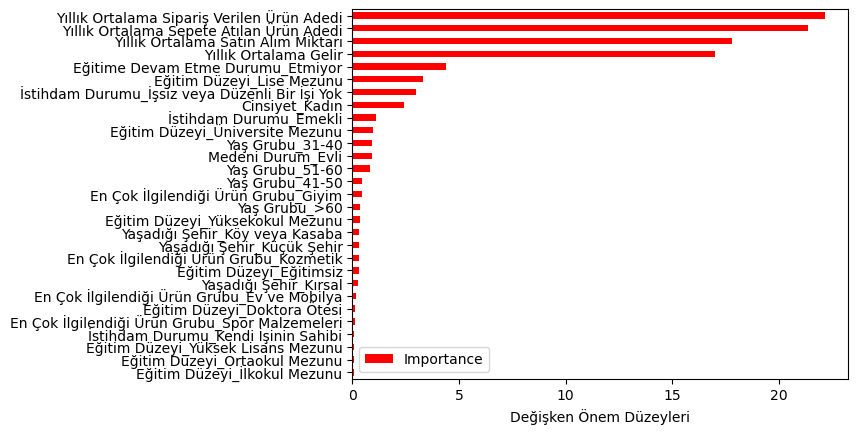

In [138]:
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Değişken Önem Düzeyleri")

### Gradient Boosting Machines

In [139]:
gbm_model = GradientBoostingClassifier().fit(x_train, y_train)

In [141]:
y_pred = gbm_model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9527629233511586

#### Model Tuning

In [142]:
gbm_model

GradientBoostingClassifier()

In [143]:
gbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
             "n_estimators": [100,500,100],
             "max_depth": [3,5,10],
             "min_samples_split": [2,5,10]}

In [144]:
gbm = GradientBoostingClassifier()

gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)

In [145]:
gbm_cv.fit(x_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [ ]:
print("En iyi parametreler: " + str(gbm_cv.best_params_))#parametreler ayarlancak dikkattt!!!!

In [ ]:
gbm = GradientBoostingClassifier(learning_rate = 0.01, 
                                 max_depth = 3,
                                min_samples_split = 5,
                                n_estimators = 500)

In [ ]:
gbm_tuned =  gbm.fit(x_train,y_train)

In [ ]:
y_pred = gbm_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

### XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_model = XGBClassifier().fit(x_train, y_train)

In [ ]:
xgb_model

In [ ]:
y_pred = xgb_model.predict(x_test)
accuracy_score(y_test, y_pred)

#### Model Tuning

In [ ]:
xgb_params = {
        'n_estimators': [100, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5,6],
        'learning_rate': [0.1,0.01,0.02,0.05],
        "min_samples_split": [2,5,10]}

In [ ]:
xgb = XGBClassifier()

xgb_cv_model = GridSearchCV(xgb, xgb_params, cv = 10, n_jobs = -1, verbose = 2)

In [ ]:
xgb_cv_model.fit(x_train, y_train)

In [ ]:
xgb_cv_model.best_params_

In [ ]:
xgb = XGBClassifier(learning_rate = 0.01, 
                    max_depth = 6,
                    min_samples_split = 2,
                    n_estimators = 100,
                    subsample = 0.8)

In [ ]:
xgb_tuned =  xgb.fit(x_train,y_train)

In [ ]:
y_pred = xgb_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

### CatBoost

In [ ]:
cat_model = CatBoostClassifier().fit(x_train, y_train)

In [ ]:
y_pred = cat_model.predict(x_test)
accuracy_score(y_test, y_pred)

#### Model Tuning

In [ ]:
catb_params = {
    'iterations': [200,500],
    'learning_rate': [0.01,0.05, 0.1],
    'depth': [3,5,8] }

In [ ]:
catb = CatBoostClassifier()
catb_cv_model = GridSearchCV(catb, catb_params, cv=5, n_jobs = -1, verbose = 2)
catb_cv_model.fit(x_train, y_train)
catb_cv_model.best_params_

In [ ]:
catb_cv_model.best_params_

In [ ]:
catb = CatBoostClassifier(iterations = 200, 
                          learning_rate = 0.05, 
                          depth = 5)

catb_tuned = catb.fit(X_train, y_train)
y_pred = catb_tuned.predict(X_test)

In [ ]:
y_pred = catb_tuned.predict(x_test)
accuracy_score(y_test, y_pred)

## Tüm Modellerin Karşılaştırılması

In [ ]:
modeller = [
loj_model,
catb_tuned,
xgb_tuned,
gbm_tuned,
rf_tuned,
cart_tuned,
mlpc_tuned,
svc_tuned,
    
]


for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    print("-"*28)
    print(isimler + ":" )
    print("Accuracy: {:.4%}".format(dogruluk))